In [1]:
import os
import sys
sys.path.append(os.path.abspath('..'))

import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt
import modules.rcnn.net as net
import modules.rcnn.shapes as shapes
import modules.rcnn.box as box

import matplotlib.patches as patches

In [2]:
H = 40
W = 40
h = H-1
w = W-1

n_min = 2
n_max = 5

x, shap = shapes.get_random_shapes(n_min,n_max,H,W)

gt_box, gt_label = shapes.shapes_to_gt(shap)
print(gt_box)
print(gt_label)

[[0.67710004 0.75       0.19475495 0.19475495]
 [0.50781491 0.25       0.45875045 0.45875045]]
[2. 1.]


In [3]:
anchor_boxes = np.array([
    [0.3,0.3],
    [0.2,0.2],
    [0.1,0.1],
    [0.05,0.05],
])

K = anchor_boxes.shape[0]

anchors = np.zeros((H,W,K,4))

for i in range(H):
    for j in range(W):
        anchors[i,j,:,0] = j/(W-1)
        anchors[i,j,:,1] = i/(H-1)
        anchors[i,j,:,2] = anchor_boxes[:,0]
        anchors[i,j,:,3] = anchor_boxes[:,1]
        
anchors_1d = anchors.reshape((-1,4))

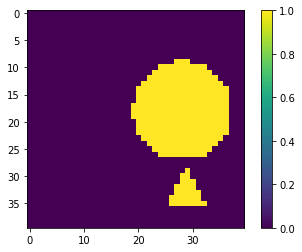

In [4]:
plt.figure()
plt.imshow(x)
plt.colorbar()
plt.show()

In [ ]:
Ntrain     = 1000
lr         = 0.001
print_step = 100

In [ ]:
x_tf       = tf.placeholder(shape=[1,H,W,1], dtype=tf.float32)
y_box_tf   = tf.placeholder(shape=[H*W*K,4], dtype=tf.float32)
y_label_tf = tf.placeholder(shape=[H*W*K], dtype=tf.float32)
y_weights_tf = tf.placeholder(shape=[H*W*K], dtype=tf.float32)

backbone = net.Backbone(input_channels=1, output_size=32)
rpn      = net.RPN(backbone, num_boxes=K, backbone_channels=32, 
                   window_size=20, hidden_size=64)

rcnn     = net.RCNN(backbone, rpn, anchors, backbone_channels=1, 
                   window_size=10, hidden_size=64, num_classes=3, obj_threshold=0.9, scope='rcnn')


crop_conv, sel_real_box, sel_real_box_xy_rot = rcnn(x_tf)

rpn_obj_logits, rpn_obj, rpn_box = rpn(x_tf)

list_box        = tf.reshape(rpn_box, shape=[-1,4])
list_obj_logits = tf.reshape(rpn_obj_logits, shape=[-1])
list_obj        = tf.reshape(rpn_obj, shape=[-1])

loss_class = tf.reduce_sum(y_weights_tf*tf.nn.sigmoid_cross_entropy_with_logits(labels=y_label_tf, 
                                         logits=list_obj_logits))

loss_box   = 10*tf.reduce_sum(y_weights_tf*y_label_tf*(tf.reduce_sum(tf.square(list_box - y_box_tf), axis=1)))

lab_sum = tf.reduce_sum(y_label_tf)

loss = loss_class+loss_box

print(loss_class, loss_box, loss)

W0820 08:49:28.874010 139904924378944 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

W0820 08:49:28.875391 139904924378944 deprecation_wrapper.py:119] From /home/gabriel/projects/centerline_detection/modules/rcnn/net.py:14: The name tf.variable_scope is deprecated. Please use tf.compat.v1.variable_scope instead.

W0820 08:49:28.876515 139904924378944 deprecation_wrapper.py:119] From /home/gabriel/projects/centerline_detection/modules/layers_new.py:35: The name tf.random_normal is deprecated. Please use tf.random.normal instead.

W0820 08:49:29.033216 139904924378944 deprecation.py:323] From /home/gabriel/anaconda3/lib/python3.7/site-packages/tensorflow/py

Tensor("Sum_1:0", shape=(), dtype=float32) Tensor("mul_7:0", shape=(), dtype=float32) Tensor("add_4:0", shape=(), dtype=float32)


In [ ]:
opt = tf.train.AdamOptimizer(lr)
train_op = opt.minimize(loss)

In [ ]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [ ]:
for i in range(Ntrain):
    
    x, shap = shapes.get_random_shapes(n_min,n_max,H,W)
    
    gt_box, gt_label = shapes.shapes_to_gt(shap)
    
    gt_t, gt_matched, gt_labels, gt_weights =\
    box.create_box_gt(anchors_1d, gt_box)
    
    x = x.reshape((1,H,W,1))
    
    sess.run(train_op, {x_tf:x, y_box_tf:gt_t, y_label_tf:gt_labels, y_weights_tf:gt_weights})
    
    if i%print_step == 0:
        l,lc,lb,ls = sess.run([loss, loss_class, loss_box, lab_sum], {x_tf:x, y_box_tf:gt_t, y_label_tf:gt_labels, y_weights_tf:gt_weights})
        
        print("iteration {}: loss={:.3f} loss_class={:.3f} loss_box={:.3f}, lab_sum={:.1f}".format(i,l, lc, lb, ls))

iteration 0: loss=4249.581 loss_class=4243.473 loss_box=6.108, lab_sum=12.0
iteration 100: loss=34.008 loss_class=34.008 loss_box=0.000, lab_sum=0.0
iteration 200: loss=9.911 loss_class=9.004 loss_box=0.907, lab_sum=4.0
iteration 300: loss=12.807 loss_class=11.479 loss_box=1.329, lab_sum=6.0
iteration 400: loss=6.734 loss_class=2.606 loss_box=4.128, lab_sum=8.0
iteration 500: loss=3.852 loss_class=2.686 loss_box=1.167, lab_sum=9.0
iteration 600: loss=2.128 loss_class=2.128 loss_box=0.000, lab_sum=0.0
iteration 700: loss=4.902 loss_class=3.099 loss_box=1.802, lab_sum=10.0
iteration 800: loss=1.747 loss_class=1.137 loss_box=0.610, lab_sum=6.0
iteration 900: loss=1.603 loss_class=0.320 loss_box=1.283, lab_sum=15.0


In [ ]:
x, shap = shapes.get_random_shapes(n_min,n_max,H,W)

gt_box, gt_label = shapes.shapes_to_gt(shap)

gt_t, gt_matched, gt_labels, gt_weights =\
box.create_box_gt(anchors_1d, gt_box)

x = x.reshape((1,H,W,1))

out_box, l_box, out_obj = sess.run([rpn_box, list_box, rpn_obj], {x_tf:x})

In [ ]:
lab = gt_labels.reshape((H,W,K))
weights = gt_weights.reshape((H,W,K))

plt.figure()
plt.imshow(x[0,:,:,0])
plt.show()

for i in range(K):
    print(i)
    plt.figure()
    plt.imshow(out_obj[0,:,:,i], cmap='gray')
    plt.colorbar()
    plt.show()
    
    plt.figure()
    plt.imshow(lab[:,:,i], cmap='gray')
    plt.colorbar()
    plt.show()
    
print("weights")
for i in range(K):
    print(i)
    plt.figure()
    plt.imshow(weights[:,:,i], cmap='gray')
    plt.colorbar()
    plt.show()

In [ ]:
predicted_boxes, predicted_obj = sess.run([list_box, list_obj],{x_tf:x})

In [ ]:
anch_p = anchors.reshape((-1,4))[predicted_obj>0.9]

In [ ]:
bp = predicted_boxes[predicted_obj>0.9]

In [ ]:
gt_p = gt_t[predicted_obj>0.9]

In [ ]:
bp_n = box.inv_bbox_transform(anch_p, bp)
gt_n = box.inv_bbox_transform(anch_p, gt_p)
print(bp_n*H)
print(gt_n*H)
print(gt_box*H)

In [ ]:
# Create figure and axes
fig,ax = plt.subplots(1, figsize=(8,8))

# Display the image
ax.imshow(x[0,:,:,0])

# Create a Rectangle patch
for b in bp_n:
    rect = patches.Rectangle((int(b[0]*w),int(b[1]*h)),int(b[2]*H),int(b[3]*H),linewidth=1,
                             edgecolor='r',facecolor='none')

    # Add the patch to the Axes
    ax.add_patch(rect)

    # Create a Rectangle patch
for b in gt_box:
    rect = patches.Rectangle((int(b[0]*w)-0.5,int(b[1]*h)-0.5),int(b[2]*H),int(b[3]*H),linewidth=1,
                             edgecolor='g',facecolor='none')

    # Add the patch to the Axes
    ax.add_patch(rect)
    
plt.show()

In [ ]:
cropped = sess.run(crop_conv,{x_tf:x})

In [ ]:
print(cropped.shape)

In [ ]:
for n in range(cropped.shape[0]):
    plt.figure()
    plt.imshow(cropped[n,:,:,0])
    plt.show()

In [ ]:
real_box, real_box_xy_rot = sess.run([sel_real_box, sel_real_box_xy_rot], {x_tf:x})
print(real_box[:4]*H)
print(real_box_xy_rot[:4]*H)
print(bp_n[:4]*H)